In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kitcolors as kit 
from shapely.geometry import LineString
from shapely.geometry import Point
import scipy.integrate as integrate
from numba import jit

In [18]:
def computeintersectiondistance(y,alpha,r):
    L = 100
    p = Point(0,0)
    c = p.buffer(r).boundary
    l = LineString([(1-L*np.cos(alpha),y-L*np.sin(alpha)), (1, y)])
    i = c.intersection(l)
    try:
        p1 = i.geoms[0].coords[0]
        p2 = i.geoms[1].coords[0]
        d1 = np.sqrt((p1[0]-1)**2+(p1[1]-y)**2)
        d2 = np.sqrt((p2[0]-1)**2+(p2[1]-y)**2)
        if d1>d2:
            t = d1
            d1 = d2
            d2 = t
        return d1, d2
    except:
        return 0,0
    
    
def computeflux(y,alpha,r,sigma):
    d1,d2 = computeintersectiondistance(y,alpha,r)
    #res = integrate.quad(lambda x: np.exp(-x*sigma),d1,d2)
    res = (np.exp(-d1*sigma)-np.exp(-d2*sigma))/sigma
    return res
def drawsketch(y=1.2,r=0.5,alpha=np.pi/4,points=[0]):
    plt.style.use("kitish")
    fig, ax = plt.subplots(1,1,figsize=(2,1.2))
    circle = plt.Circle((0, 0), r, color=kit.green)
    ax.add_artist(circle)
    ax.axvline(1,color =kit.black)
    l = 0.2
    _,L = computeintersectiondistance(y,alpha,r)
    #ax.arrow(1,y,l*np.cos(alpha),l*np.sin(alpha),head_width=0.1,facecolor="k")
    #ax.plot([1,1-L*np.cos(alpha)],[y,y-L*np.sin(alpha)],"--",color="k",lw = 1)
    #ax.text(1+0.1,y-0.1,r"$\alpha$")
    ax.set_xlim([-0.5,1+r+l])
    ax.set_ylim([-0.5,0.5])
    ax.set_aspect('equal', 'box')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_yticks([])
    ax.set_xticks([])
   # ax.text(-0.43,0.4,r"$r$")
   # ax.scatter(0,0,c="k",s=10,zorder=100)
   # ax.scatter(1,y,c="k",s=10,zorder=100)
    ax.text(1,0.6,r"$x=1$",horizontalalignment="center")
    for point,marker,color in zip(points,["^","o","s"],[kit.orange,kit.purple,kit.blue]):
        ax.scatter(1,point,s=30,marker=marker,color = color,zorder=100)
    ax.grid(False)

    # Hide axes ticks
    plt.grid(b=None)
    plt.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.plot([1,1+0.4],[y,y],"k",'--')
    plt.savefig("Setup.pdf")
def computefluxes(n,m,r=0.5,sigma=1):
    ALPHA = np.linspace(-np.pi/2,np.pi/2,n)
    Y = np.linspace(-1,1,m)
    F = np.zeros((n,m))
    for i,ai in enumerate(ALPHA):
        for j,yj in enumerate(Y):
            f = computeflux(yj,ai,r,sigma)
            F[i,j] = f
    return F
def integrand(rad,theta,y,sigma):
    xx,yy = np.cos(theta)*rad, np.sin(theta)*rad
    d2 = (xx-1)**2+(yy-y)**2
    d = d2**0.5
    return np.exp(-sigma*d)*rad

def computeexactscalarflux(y,m,r,sigma):
    Y = np.linspace(-1,1,m)
    Phi = np.zeros(m)
    for i,yi in enumerate(Y):
        
        def integr(rad,theta):
            return integrand(rad,theta,yi,sigma)

        result = integrate.dblquad(integr,-np.pi,np.pi,0,r)
        Phi[i] = result[0]
    return Phi


def computeexactscalarfluxV2(y,m,r,sigma):
    Y = np.linspace(-1,1,m)
    Phi = np.zeros(m)
    for i,yi in enumerate(Y):
        def integrand(alpha):
            return computeflux(yi,alpha,r,sigma)


        result = integrate.quad(integrand,-np.pi,np.pi)
        Phi[i] = result[0]
    return Phi

def plotresults(n,m,F,referencephi,points,cmap="magma",r=0.4):
    from matplotlib import gridspec
    plt.style.use("kitish")
    ALPHA = np.linspace(-np.pi/2,np.pi/2,n)
    Y = np.linspace(-1,1,m)
    #fig,axs = plt.subplots(1,4)
    #fig = plt.figure() 
    #gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,2]) 
    #ax = plt.subplot(gs[0])
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(1,10)
    ax = fig.add_subplot(gs[:3])
    #ax = axs[0]
    cs = ax.pcolormesh(F.T,cmap = cmap,linewidth=0,rasterized=True)
    ax.set_ylabel(r"$y$",labelpad = -3)
    ax.set_xlabel(r"$\alpha$")
    ax.set_xticks([0,n/2,n])
    ax.set_xticklabels([r"$-\pi/2$",r"$0$", r"$\pi/2$"])
    ax.set_yticklabels([r"$-1$",r"$0$", r"$1$"])
    ax.set_yticks([0,m/2,m])
    clb = fig.colorbar(cs,orientation="vertical",ax=ax,pad = -0.15)
    clb.ax.set_title(r"$\psi(y,\alpha)$",pad = 7)
    plt.setp(ax.spines.values(), linewidth=0)
    
    #ax = plt.subplot(gs[1])
    ax = fig.add_subplot(gs[3:6]) 
    ax2 = fig.add_subplot(gs[3:6])
    
    #ax = axs[1]
    ax.set_xlabel(r"$\phi(y)$")

    phi = np.zeros(m)
    for i in range(m):
        phi[i] = np.sum(F[:,i])/n
    ax.plot(phi,Y,"k",lw = 1,color=kit.black)
    #ax.set_xticklabels([r"$-\pi/2$",r"$0$", r"$\pi/2$"])
    ax.set_ylabel(r"$y$",labelpad = -3)
    ax.set_yticks([-1,0,1])
    ax.set_ylim([-1,1])
    #ax.set_xlim([0,0.002])
    ax.set_xlim([0.03,0.07])#0.9*np.min(phi),1.1*np.max(phi)])
    ax.set_yticklabels([r"$-1$",r"$0$", r"$1$"])
    
    #ax = axs[2:]
#    ax = plt.subplot(gs[2])
    ax = fig.add_subplot(gs[6:])
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"$\psi(y,\alpha)$")
    for point,marker,color,order in zip(points,["^","o","s"],[kit.orange,kit.purple
                                                              ,kit.blue],[100,70,60]):
        f = np.zeros(len(ALPHA))
        for i,ai in enumerate(ALPHA):

            res = computeflux(point,ai,r,sigma)
            
            f[i] = res
        ax2.scatter(sum(f)/len(f),point,s=20,marker=marker,color = color,zorder=100)
        ax.plot(f,color=color,marker = marker,lw = 1,ms=4,zorder = order)
        ax.plot(f,color=color,marker = marker,lw = 0,ms=4,zorder = order,label=r"$y={}$".format(point))
        #ax.scatter(np.arange(len(ALPHA)),f,label=r"$y={}$".format(point),color=color,s=20,marker=marker)
        
    ax.set_xticks([0,n//2,n-1])
    ax.set_xticklabels([r"$-\pi/2$",r"$0$", r"$\pi/2$"])
    from matplotlib.font_manager import FontProperties
    fontP = FontProperties()
    fontP.set_size('x-small')
 #   legend([plot1], "title", 
    ax.legend(prop=fontP,loc='upper left',
          ncol=1, bbox_to_anchor=(-0.3, 1.1),fancybox=True,framealpha=1)
    plt.savefig("figure{}_{}_{}.pdf".format(n,m,int(r*10)))
    return phi,referencephi


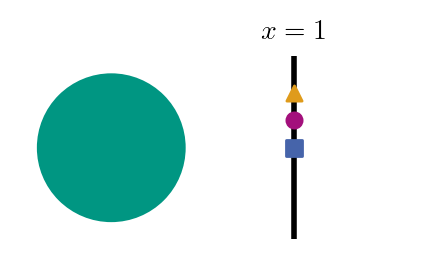

In [19]:
points = [0.3,0.15,0]
r = 0.4
drawsketch(r=r,points=points)

In [22]:
n,m,sigma = 21,100,1
referencephi =computeexactscalarflux(1.0,m,r,sigma)
F=computefluxes(n,m,r,sigma)

/home/qd4314/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


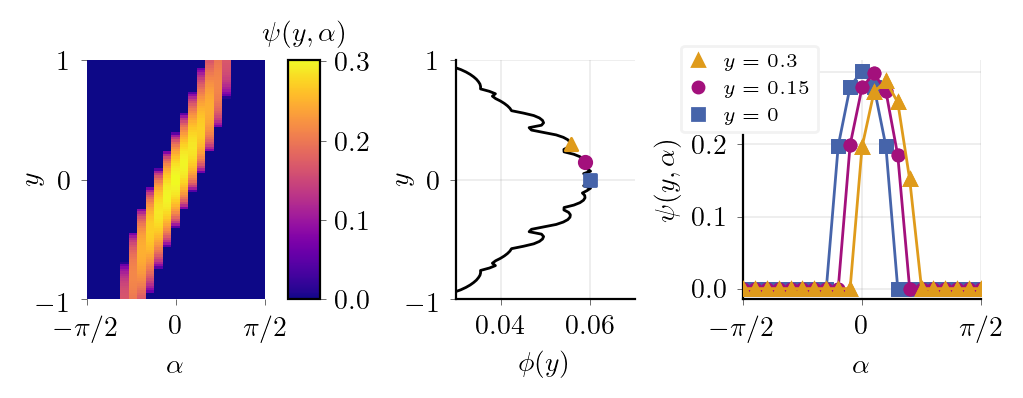

In [23]:
phi,refphi = plotresults(n,m,F,referencephi,points=points,cmap = "plasma",r=r)